In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch
from torch.utils.data import Dataset, DataLoader

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [5]:
!unzip processed_corpus.json.zip -d data

Archive:  processed_corpus.json.zip
  inflating: data/processed_corpus.json  


In [6]:
with open('data/processed_corpus.json') as f:
    corpus = json.load(f)

In [7]:
len(corpus)

100000

In [8]:
type(corpus)

list

In [9]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


In [10]:
sample_text = 'вопрос почему например китайский японский UNK'.split(' ')

# Реализуйте разделение предложения на примеры методом CBOW

In [ ]:
' '.join(sample_text)

'вопрос почему например китайский японский UNK'

In [ ]:
def cbow_split(tokens, window, pad_token='PAD'):

    splits = []

    # CODE

    tokens =  [pad_token] * window + tokens + [pad_token] * window

    for i in range(window, len(tokens) - window):
        splits.append((tokens[i - window: i],
                       tokens[i], tokens[i + 1: i + window + 1]))

    return splits

In [ ]:
expected_3 = [(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]

In [ ]:
cbow_split(sample_text, window=2) == expected_3

True

In [ ]:
expected_4 = [(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]

In [ ]:
cbow_split(sample_text, window=3) == expected_4

True

# Реализуйте разделение предложения на примеры методом Skipgram

In [ ]:
' '.join(sample_text)

'вопрос почему например китайский японский UNK'

In [ ]:
def skipgram_split(tokens, window):

    splits = []

    # CODE

    for i in range(len(tokens)):
        for j in range(window, 0, -1):
            if i - j >= 0 and i - j != i:
                splits.append((tokens[i - j], tokens[i]))
        for j in range(1, window + 1):
            if i + j < len(tokens):
                splits.append((tokens[i + j], tokens[i]))

    return splits

In [ ]:
expected_1 = [('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

In [ ]:
skipgram_split(sample_text, window=2) == expected_1

True

In [ ]:
expected_2 = [('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

In [ ]:
skipgram_split(sample_text, window=3) == expected_2

True

# Index

In [11]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [12]:
len(word2index)

13076

In [13]:
word2index['UNK']

1

In [14]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [ ]:
# from torch.utils.data import Dataset, DataLoader

In [ ]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [ ]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.1787321 , 0.51786744, 0.97939732, 0.81240408],
       [0.46268084, 0.60909193, 0.9207133 , 0.17660753],
       [0.97412671, 0.11804741, 0.01920934, 0.19168962],
       [0.19594824, 0.91077239, 0.7190771 , 0.81322248],
       [0.35733331, 0.91358802, 0.84725186, 0.66877617],
       [0.50944908, 0.89889334, 0.81747044, 0.33295419],
       [0.79691699, 0.17043838, 0.97488061, 0.84235193],
       [0.79318332, 0.80316832, 0.65963328, 0.31501182],
       [0.45121765, 0.85259342, 0.26601224, 0.91839757],
       [0.0389066 , 0.41552952, 0.22514525, 0.54930404]])

In [ ]:
some_data_y

array([2, 0, 0, ..., 2, 0, 0])

In [ ]:
class ToyDataset(Dataset):

    def __init__(self, data_x, data_y):

        super().__init__()

        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):

        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета

        return len(self.data_x)

    def __getitem__(self, idx):

        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу

        return self.data_x[idx], self.data_y[idx]

In [ ]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [ ]:
some_dataset[5], some_dataset[467]

((array([0.50944908, 0.89889334, 0.81747044, 0.33295419]), 2),
 (array([0.02259839, 0.8410403 , 0.47406338, 0.94769795]), 2))

In [ ]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [ ]:
for x, y in some_loader:
    break

len(x), x

(16,
 tensor([[0.3159, 0.5746, 0.1657, 0.1453],
         [0.1220, 0.9171, 0.9184, 0.9767],
         [0.4921, 0.1628, 0.8056, 0.2032],
         [0.8078, 0.2501, 0.9748, 0.1730],
         [0.3025, 0.1886, 0.0988, 0.8691],
         [0.8662, 0.9923, 0.4967, 0.8338],
         [0.0762, 0.0977, 0.1633, 0.9034],
         [0.9564, 0.2255, 0.2885, 0.6419],
         [0.5030, 0.8083, 0.1307, 0.5732],
         [0.9187, 0.6392, 0.2524, 0.1817],
         [0.7093, 0.4360, 0.3366, 0.3121],
         [0.3111, 0.7918, 0.4204, 0.6715],
         [0.4110, 0.3809, 0.9478, 0.2517],
         [0.4780, 0.9931, 0.4882, 0.3431],
         [0.5973, 0.6822, 0.4993, 0.0088],
         [0.7256, 0.4553, 0.6478, 0.0236]], dtype=torch.float64))

In [ ]:
for x, y in some_loader:
    pass

len(x)

15

In [ ]:
# почему 13? -- here 15
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [ ]:
class ToyDataset(Dataset):

    def __init__(self, data_x, data_y):

        super().__init__()

        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):

        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета

        return len(self.data_x)

    @staticmethod
    def add_pow_features(x, n=2):

        return np.concatenate([x, x ** n])

    @staticmethod
    def add_log_features(x):

        return np.concatenate([x, np.log(x)])

    def __getitem__(self, idx):

        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу

        x = self.data_x[idx]

        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)

        y = self.data_y[idx]

        return x, y

In [ ]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [ ]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [ ]:
for x, y in toy_loader:
    break

In [ ]:
x.shape

torch.Size([128, 32])

In [ ]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[ 1.7873e-01,  5.1787e-01,  9.7940e-01,  ..., -3.9482e+00,
         -1.2491e-01, -1.2465e+00],
        [ 4.6268e-01,  6.0909e-01,  9.2071e-01,  ..., -2.9747e+00,
         -4.9564e-01, -1.0403e+01],
        [ 9.7413e-01,  1.1805e-01,  1.9209e-02,  ..., -1.2820e+01,
         -2.3714e+01, -9.9113e+00],
        ...,
        [ 6.8490e-01,  8.4059e-02,  2.0248e-01,  ..., -1.4857e+01,
         -9.5827e+00, -1.2417e+00],
        [ 6.5374e-01,  6.1813e-02,  9.3151e-01,  ..., -1.6702e+01,
         -4.2566e-01, -8.2681e+00],
        [ 1.0236e-01,  5.2315e-01,  5.9404e-01,  ..., -3.8874e+00,
         -3.1249e+00, -4.7313e+00]], dtype=torch.float64)

In [ ]:
y

tensor([2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 2, 0, 2, 1,
        2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 0, 1, 0, 1, 0, 2, 0, 0, 2, 1, 1, 0, 2, 1,
        1, 1, 1, 2, 2, 0, 2, 0, 0, 1, 1, 2, 0, 0, 1, 0, 2, 1, 0, 2, 1, 2, 2, 2,
        0, 1, 2, 0, 1, 1, 0, 2, 2, 1, 0, 1, 0, 0, 2, 0, 1, 1, 2, 1, 0, 0, 0, 1,
        2, 1, 2, 2, 2, 0, 1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 1, 2, 2, 0, 2, 1,
        2, 0, 1, 2, 1, 0, 2, 2])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)

loss.item()

1.1190491914749146

# Датасет и модель: пример на CBOW

In [ ]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

In [ ]:
class CBOW(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim, pad_index):

        super().__init__()

        if pad_index > 0:
            vocab_size += 1

        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)

        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)

    def forward(self, x):

        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)

        return x

# Мы будем учить через Skipgram
Реализуем читалку данных

In [15]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index

        self.window = window
        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]
        self.collect_verbose = collect_verbose

        self.data = []
        self.collect_data() # что делается в этой строке?

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        # CODE
        # вставить здесь функцию, которые вы писали раньше

        splits = []

        for i in range(len(tokenized_text)):
            for j in range(self.window, 0, -1):
                if i - j >= 0 and i - j != i:
                    splits.append((tokenized_text[i - j], tokenized_text[i]))
            for j in range(1, self.window + 1):
                if i + j < len(tokenized_text):
                    splits.append((tokenized_text[i + j], tokenized_text[i]))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else
                self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):

        # CODE

        context, central_word = self.data[idx]

        return context, central_word


In [ ]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils,
# и относительным импортом достать его
# from .word2vec_utils import SkipgramDataset

In [16]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:01<00:00, 55137.90it/s]


In [17]:
BATCH_SIZE = 512

In [18]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [19]:
for x, y in dataset_loader:
    break

In [20]:
x[:5]

tensor([   8,  252,   10,  476, 4512])

In [21]:
y[:5]

tensor([ 48,  32,  66, 626,  89])

In [22]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

# Реализуем модель Skipgram

In [23]:
# CODE
class SkipGram(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim):

        super().__init__()

        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                               embedding_dim=embedding_dim)

        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)

    def forward(self, x):

        x = self.in_embedding(x)
        x = self.out_embedding(x)

        return x

In [ ]:
#from word2vec_utils import SkipGram

In [24]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
# обычно берут 300
EMBEDDING_DIM = 20

In [25]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [26]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [27]:
epochs = 3
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0003)

losses = []
for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset),
                            desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            # CODE

            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)

            # CODE

            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            progress_bar.set_postfix(loss=np.mean(losses[-100:]))
            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2983124/2983124 [07:07<00:00, 6978.39it/s, loss=7.08]


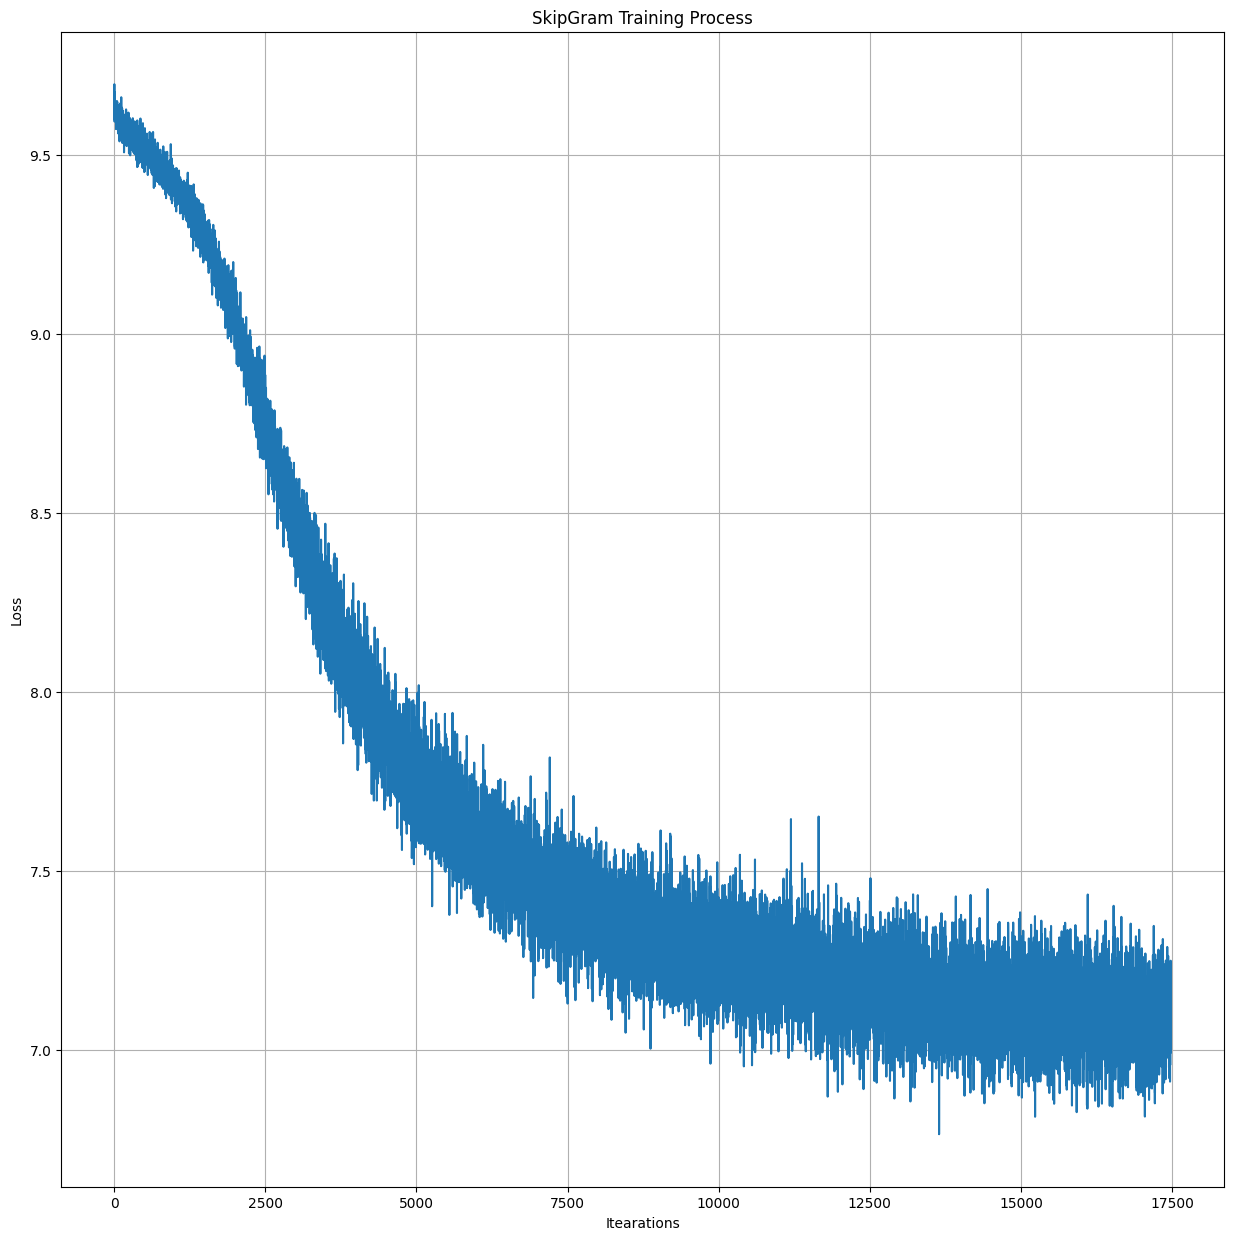

In [28]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [29]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [ ]:
def cos_sim(embedding_matrix, token2id, word1, word2):

    i1 = token2id[word1]
    i2 = token2id[word2]

    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]

    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))

    similarity = torch.dot(v1_n, v2_n).item()

    return similarity

In [ ]:
embedding_matrix = model.in_embedding.weight.detach()

In [ ]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.9070236086845398

In [ ]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.5811260342597961

In [ ]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.7068394422531128

In [ ]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.6769703030586243

In [ ]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "поворот" равна 0.206'

In [ ]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [ ]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [ ]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.004s...
[t-SNE] Computed neighbors for 13076 samples in 1.334s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

In [ ]:
top_words = [a for a,_ in top_sorted_freq]

In [ ]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

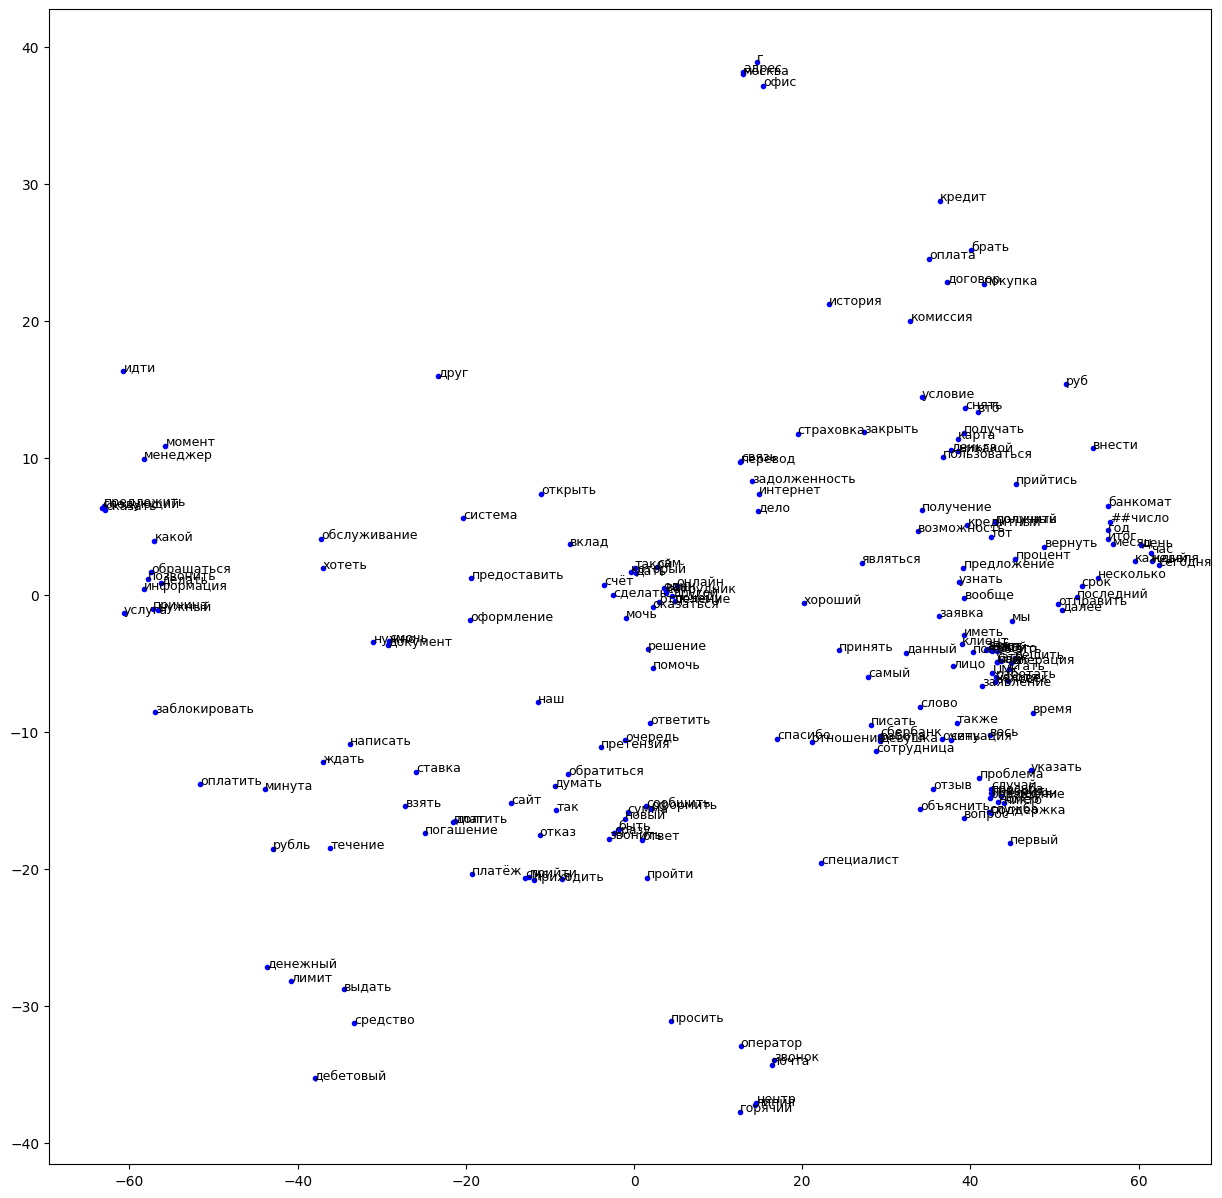

In [ ]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценки качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). (Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож на гугл аналогии, просто иначе составлен.) Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делали на 9 баллов